In [1]:
import requests
from PIL import Image
import torch

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

/home/thiendc/projects/video_summarization/train_soccernet/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "/home/thiendc/projects/video_summarization/train_soccernet/ref.jpg"
image = Image.open(url).convert("RGB")
text_labels = ["Referee"]

inputs = processor(text=text_labels, images=image, return_tensors="pt")
outputs = model(**inputs)

target_sizes = torch.tensor([(image.height, image.width)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.28, text_labels=text_labels
)
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

Detected R with confidence 0.463 at location [65.51, 47.44, 299.73, 226.29]
Detected R with confidence 0.49 at location [65.03, 45.44, 204.83, 224.51]


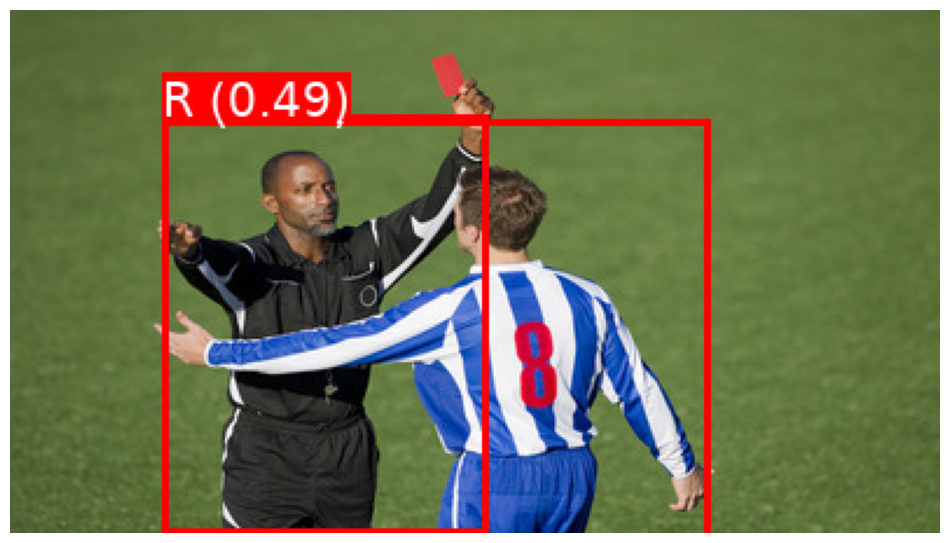

In [3]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Ảnh gốc của bạn
image = Image.open("/home/thiendc/projects/video_summarization/train_soccernet/ref.jpg").convert("RGB")

# Ví dụ result bạn đã có
# boxes, scores, text_labels đã từ processor.post_process_grounded_object_detection()

draw = ImageDraw.Draw(image)

# Tuỳ vào font, nếu bạn không cần tiếng Việt hoặc font đặc biệt thì có thể bỏ qua
try:
    font = ImageFont.truetype("DejaVuSans.ttf", size=20)
except:
    font = ImageFont.load_default()

for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box

    draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="red", width=3)

    text = f"{text_label} ({round(score.item(), 2)})"
    text_size = draw.textbbox((0, 0), text, font=font)
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]

    draw.rectangle(
        [(xmin, ymin - text_height), (xmin + text_width, ymin)],
        fill="red"
    )
    draw.text((xmin, ymin - text_height), text, fill="white", font=font)

# Hiển thị bằng matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
import requests
from PIL import Image
import torch

from transformers import Owlv2Processor, Owlv2ForObjectDetection

# --- Bước 1: Khởi tạo mô hình và xử lý đầu vào (giống như code của bạn) ---
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

url = "/home/thiendc/projects/video_summarization/train_soccernet/ref.jpg"
image = Image.open(url).convert("RGB")
text_labels = ["Referee"]

inputs = processor(text=text_labels, images=image, return_tensors="pt")

# --- Bước 2: Chạy mô hình và giữ lại ĐẦU RA THÔ ---
with torch.no_grad(): # Quan trọng: Dùng no_grad để tiết kiệm bộ nhớ khi không huấn luyện
    outputs = model(**inputs)

# outputs bây giờ chứa mọi thứ chúng ta cần.

# --- Bước 3: Tìm chỉ số (index) của bounding box bạn quan tâm ---

# Đầu tiên, chúng ta cần tính toán lại điểm tin cậy (scores) từ logits thô.
# Owlv2 sử dụng sigmoid cho phần classification.
# Shape của logits: [batch_size, num_queries, num_classes]
# Trong trường hợp này là [1, 900, 1]
all_scores = torch.sigmoid(outputs.logits).squeeze() # Bỏ các chiều không cần thiết

# Bây giờ, tìm chỉ số có score gần bằng 0.17
target_score =0.49   
# torch.isclose rất hữu ích để so sánh số thực, atol là dung sai (absolute tolerance)
possible_indices = torch.nonzero(torch.isclose(all_scores, torch.tensor(target_score), atol=1e-3)).squeeze()

if possible_indices.numel() == 0:
    print(f"Không tìm thấy box nào có score xấp xỉ {target_score}.")
    # In ra các score cao nhất để debug
    top_scores, _ = torch.topk(all_scores, 5)
    print("5 scores cao nhất là:", [round(s.item(), 3) for s in top_scores])
else:
    # Giả sử chúng ta lấy chỉ số đầu tiên tìm được
    target_index = possible_indices.item()
    print(f"Đã tìm thấy box có score ~{target_score} tại chỉ số (index) thô: {target_index}")

    # --- Bước 4: DÙNG CHỈ SỐ ĐÓ ĐỂ TRÍCH XUẤT FEATURE VECTOR ---
    
    # last_hidden_state có shape: [batch_size, num_queries, hidden_dim]
    all_feature_vectors = outputs.vision_model_output.last_hidden_state

    # Lấy feature vector tương ứng với box chúng ta đã tìm thấy
    # Dùng [0] vì batch size của chúng ta là 1
    feature_vector = all_feature_vectors[0, target_index, :]

    print("\nTrích xuất thành công feature vector!")
    print(f"Shape của feature vector: {feature_vector.shape}")
    # In ra một phần của vector để xác nhận
    print(f"Một phần của vector: {feature_vector[:10]}...") 

# --- (Phần code cũ của bạn để xác nhận lại) ---
print("\n--- Xác nhận lại với hàm post_process ---")
target_sizes = torch.tensor([(image.height, image.width)])
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.281, text_labels=text_labels
)
result = results[0]
boxes, scores, text_labels_processed = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels_processed):
    box_rounded = [round(i, 2) for i in box.tolist()]
    score_rounded = round(score.item(), 3)
    # Highlight a score close to our target to show it matches
    highlight = " <--- TARGET ĐÂY" if abs(score_rounded - target_score) < 1e-2 else ""
    print(f"Detected {text_label} with confidence {score_rounded} at location {box_rounded}{highlight}")

Đã tìm thấy box có score ~0.49 tại chỉ số (index) thô: 1817

Trích xuất thành công feature vector!
Shape của feature vector: torch.Size([768])
Một phần của vector: tensor([-0.1554, -1.1205,  0.2838, -0.7782,  4.1379,  0.4715,  0.6519, -0.1366,
        -1.2255,  1.6506])...

--- Xác nhận lại với hàm post_process ---
Detected R with confidence 0.463 at location [65.51, 47.44, 299.73, 226.29]
Detected R with confidence 0.49 at location [65.03, 45.44, 204.83, 224.51] <--- TARGET ĐÂY


In [5]:
import numpy as np

np.save("referee_feature_3.npy", feature_vector)

In [7]:
import numpy as np

feature_vector_1 = np.load("/home/thiendc/projects/video_summarization/train_soccernet/referee_feature_3.npy")
feature_vector_2 = np.load("/home/thiendc/projects/video_summarization/train_soccernet/referee_feature_2.npy") 
print("Shape vector 1:", feature_vector_1.shape)
print("Shape vector 2:", feature_vector_2.shape)

# Euclidean distance
euclidean_dist = np.linalg.norm(feature_vector_1 - feature_vector_2)
print("Euclidean distance:", euclidean_dist)

# Cosine similarity
dot_product = np.dot(feature_vector_1, feature_vector_2)
norm_1 = np.linalg.norm(feature_vector_1)
norm_2 = np.linalg.norm(feature_vector_2)
cosine_similarity = dot_product / (norm_1 * norm_2)

# Cosine distance
cosine_distance = 1 - cosine_similarity

print("Cosine similarity:", cosine_similarity)
print("Cosine distance:", cosine_distance)


Shape vector 1: (768,)
Shape vector 2: (768,)
Euclidean distance: 39.64819
Cosine similarity: 0.6028382
Cosine distance: 0.3971617817878723


In [8]:
feature_1 = torch.from_numpy(np.load("referee_feature_1.npy"))
feature_2 = torch.from_numpy(np.load("referee_feature_2.npy"))
feature_3 = torch.from_numpy(np.load("referee_feature_3.npy"))

print(f"Đã tải thành công 3 feature vector. Shape của mỗi vector: {feature_1.shape}")

# Tạo một danh sách để chứa các vector
feature_list = [feature_1, feature_2, feature_3]

# --- BƯỚC 2: Ghép các vector lại với nhau ---
# torch.stack sẽ tạo một chiều mới, biến danh sách các tensor 1D thành một tensor 2D.
# Chiều mới sẽ là chiều đầu tiên (dim=0).
stacked_features = torch.stack(feature_list, dim=0)

# Shape của stacked_features sẽ là (3, 768), 
# trong đó 3 là số lượng vector, 768 là chiều của mỗi vector.
print(f"\nShape của tensor sau khi ghép (stack): {stacked_features.shape}")

# --- BƯỚC 3: Tính trung bình cộng (Average Pooling) ---
# torch.mean(tensor, dim=0) sẽ tính trung bình dọc theo chiều thứ 0.
# Nó sẽ lấy trung bình của 3 vector lại với nhau.
average_embedding = torch.mean(stacked_features, dim=0)

print("\nTính toán embedding trung bình thành công!")
print(f"Shape của embedding trung bình cuối cùng: {average_embedding.shape}")
print(f"Một phần của embedding trung bình: {average_embedding[:10]}...")

# --- BƯỚC 4 (Tùy chọn): Lưu embedding trung bình lại ---
# Chuyển về numpy để lưu
prototype_embedding_numpy = average_embedding.numpy()
np.save("referee_prototype_embedding.npy", prototype_embedding_numpy)
print("\nĐã lưu embedding nguyên mẫu vào file 'referee_prototype_embedding.npy'.")



Đã tải thành công 3 feature vector. Shape của mỗi vector: torch.Size([768])

Shape của tensor sau khi ghép (stack): torch.Size([3, 768])

Tính toán embedding trung bình thành công!
Shape của embedding trung bình cuối cùng: torch.Size([768])
Một phần của embedding trung bình: tensor([ 0.2929, -0.7709,  0.7457, -0.5537,  3.2384,  0.7843,  0.7791, -0.2266,
        -1.6697,  1.1991])...

Đã lưu embedding nguyên mẫu vào file 'referee_prototype_embedding.npy'.


In [1]:
# Thay đường dẫn model CLIP local của bạn:
from transformers import AutoTokenizer, Siglip2TextModel
import numpy as np
import torch
model_name = "google/siglip2-base-patch16-224"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("texts2.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]
print(f"Loaded {len(prompts)} prompts")
# ==== LOAD MODEL ====
print("Loading CLIP tokenizer and text model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = Siglip2TextModel.from_pretrained(model_name).to(device)
text_model.eval()

# ==== ENCODE ====
print("Encoding prompts...")
with torch.no_grad():
    inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
    text_features = text_model(**inputs)
    class_embed = text_features.last_hidden_state.detach().cpu().numpy()

print(f"Embeddings shape: {class_embed.shape}")

# ==== SAVE ====
np.save("/home/thiendc/projects/video_summarization/train_soccernet/siglip2_embeddings.npy", class_embed)


/home/thiendc/projects/video_summarization/train_soccernet/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 18 prompts
Loading CLIP tokenizer and text model...


You are using a model of type siglip_text_model to instantiate a model of type siglip2_text_model. This is not supported for all configurations of models and can yield errors.


Encoding prompts...
Embeddings shape: (18, 5, 768)


In [2]:
import numpy as np

embeddings = np.load("/home/thiendc/projects/video_summarization/train_soccernet/siglip2_embeddings.npy")

print(embeddings.shape)

(18, 768)


In [1]:
import torch
import torch.nn.functional as F
from transformers import WhisperModel
import numpy as np

@torch.no_grad()
def whisper_layer_entropy(model: WhisperModel, input_features: torch.Tensor, device: str = "cuda") -> torch.Tensor:
    """
    Tính entropy trung bình trên mỗi layer của Whisper encoder.
    Args:
        model: WhisperModel đã load pre-trained weights.
        input_features: Tensor [B, 80, 3000] (log-mel, đã pad/crop).
        device: Thiết bị chạy (mặc định "cuda").
    Returns:
        entropy_per_layer: Tensor [num_layers], mỗi giá trị là entropy trung bình của layer đó.
    """
    model = model.to(device).eval()
    input_features = input_features.to(device)
    
    # Forward pass qua encoder với output_hidden_states=True
    encoder_outputs = model.encoder(
        input_features=input_features,
        output_hidden_states=True,
        return_dict=True
    )
    
    # Lấy hidden states từ tất cả layers
    hidden_states = encoder_outputs.hidden_states  # Tuple của các tensor [B, seq_len, hidden_dim]
    num_layers = len(hidden_states)
    
    entropies = []
    
    for layer_idx, hidden_state in enumerate(hidden_states):
        # hidden_state: [B, seq_len, hidden_dim]
        B, seq_len, hidden_dim = hidden_state.shape
        
        # Flatten để tính entropy
        flat_hidden = hidden_state.reshape(-1, hidden_dim)  # [B*seq_len, hidden_dim]
        
        # Tính softmax để có distribution
        probs = F.softmax(flat_hidden, dim=-1)  # [B*seq_len, hidden_dim]
        
        # Tính entropy: -sum(p * log(p))
        log_probs = torch.log(probs + 1e-12)  # Tránh log(0)
        entropy = -torch.sum(probs * log_probs, dim=-1)  # [B*seq_len]
        
        # Lấy entropy trung bình
        avg_entropy = torch.mean(entropy)
        entropies.append(avg_entropy)
        
        print(f"Layer {layer_idx:2d}: Entropy = {avg_entropy:.4f}")
    
    return torch.tensor(entropies)

def create_dummy_logmel(batch_size: int = 2, mel_bins: int = 80, time_frames: int = 3000) -> torch.Tensor:
    """
    Tạo dummy log-mel spectrogram data.
    Args:
        batch_size: Kích thước batch
        mel_bins: Số mel frequency bins (80 cho Whisper)
        time_frames: Số time frames (3000 cho whisper-base)
    Returns:
        dummy_logmel: Tensor [B, mel_bins, time_frames]
    """
    # Tạo log-mel ngẫu nhiên trong khoảng hợp lý [-80, 0] (dB scale)
    dummy_logmel = torch.randn(batch_size, mel_bins, time_frames) * 20 - 40
    return dummy_logmel

def main():
    """
    Hàm chính: Load model, tạo dummy data, và tính entropy.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🔥 Sử dụng device: {device}")
    
    # 1. Load Whisper model
    print("📥 Loading Whisper model...")
    model_name = "openai/whisper-small"
    model = WhisperModel.from_pretrained(model_name)
    print(f"✅ Đã load model: {model_name}")
    print(f"   - Encoder layers: {model.config.encoder_layers}")
    print(f"   - Hidden size: {model.config.d_model}")
    
    # 2. Tạo dummy log-mel data
    print("\n🎵 Tạo dummy log-mel data...")
    batch_size = 2
    dummy_logmel = create_dummy_logmel(batch_size=batch_size)
    print(f"   - Input shape: {dummy_logmel.shape}")  # [2, 80, 3000]
    
    # 3. Tính entropy từng layer
    print(f"\n🧮 Tính entropy từng layer...")
    print("=" * 40)
    
    layer_entropies = whisper_layer_entropy(
        model=model,
        input_features=dummy_logmel,
        device=device
    )
    
    print("=" * 40)
    print(f"\n📊 Kết quả tổng hợp:")
    print(f"   - Highest entropy layer: {torch.argmax(layer_entropies).item()} (entropy = {torch.max(layer_entropies):.4f})")
    print(f"   - Lowest entropy layer:  {torch.argmin(layer_entropies).item()} (entropy = {torch.min(layer_entropies):.4f})")
    print(f"   - Average entropy: {torch.mean(layer_entropies):.4f}")
    
    # 4. Gợi ý layer để finetune
    print(f"\n💡 Gợi ý finetune:")
    top_entropy_layers = torch.argsort(layer_entropies, descending=True)[:5]
    print(f"   - Top 3 layers có entropy cao nhất: {top_entropy_layers.tolist()}")
    print(f"   - Nên finetune các layer này vì chúng có thông tin biến thiên nhiều nhất.")

if __name__ == "__main__":
    main()

/home/thiendc/projects/video_summarization/train_soccernet/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 Sử dụng device: cuda
📥 Loading Whisper model...
✅ Đã load model: openai/whisper-small
   - Encoder layers: 12
   - Hidden size: 768

🎵 Tạo dummy log-mel data...
   - Input shape: torch.Size([2, 80, 3000])

🧮 Tính entropy từng layer...
Layer  0: Entropy = 0.1038
Layer  1: Entropy = 0.1125
Layer  2: Entropy = 0.1160
Layer  3: Entropy = 0.1210
Layer  4: Entropy = 0.1268
Layer  5: Entropy = 0.1374
Layer  6: Entropy = 0.1402
Layer  7: Entropy = 0.1429
Layer  8: Entropy = 0.1440
Layer  9: Entropy = 0.1526
Layer 10: Entropy = 0.1648
Layer 11: Entropy = 0.1484
Layer 12: Entropy = 1.4181

📊 Kết quả tổng hợp:
   - Highest entropy layer: 12 (entropy = 1.4181)
   - Lowest entropy layer:  0 (entropy = 0.1038)
   - Average entropy: 0.2330

💡 Gợi ý finetune:
   - Top 3 layers có entropy cao nhất: [12, 10, 9, 11, 8]
   - Nên finetune các layer này vì chúng có thông tin biến thiên nhiều nhất.


In [7]:
import cv2

# video_path = "/home/storage/thiendc/soccernet/test/spain_laliga/2014-2015/2015-04-25 - 17-00 Espanyol 0 - 2 Barcelona/2_224p.mkv"
video_path = "/home/storage/thiendc/soccernet/train/italy_serie-a/2016-2017/2017-02-04 - 22-45 Bologna 1 - 7 Napoli/1_224p.mkv"
# Thời điểm muốn trích xuất (giây)
minute = 19
second = 39
timestamp = minute * 60 + second

# Mở video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Không mở được video")
    exit()

# Lấy FPS
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"FPS: {fps}")

# Tính số frame cần đọc
frame_number = int(fps * timestamp)
print(f"Frame number cần trích: {frame_number}")

# Di chuyển đến frame đó
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Đọc frame
ret, frame = cap.read()

if ret:
    output_path = f"frame_{minute}m{second}s.jpg"
    cv2.imwrite(output_path, frame)
    print(f"Đã lưu frame tại: {output_path}")
else:
    print("Không đọc được frame!")

cap.release()


FPS: 25.0
Frame number cần trích: 29475
Đã lưu frame tại: frame_19m39s.jpg


In [1]:
import os

def has_exactly_two_mkv_files(directory: str) -> bool:
    count = 0
    with os.scandir(directory) as entries:
        for entry in entries:
            # Check if the current entry is a file and ends with ".mkv"
            if entry.is_file() and entry.name.endswith(".mkv"):
                count += 1
                # Exit early if more than two such files are found
                if count > 2:
                    return False
    return count == 2
def list_end_directories(path: str) -> list:
    """
    Recursively traverse a directory and 
    return all paths that are files (end of branch).
    """
    end_files = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.startswith('SoccerNetV2'):                
                pass
            else:
                refined_path = os.path.join(root, file)
                # print(refined_path)
                # if has_exactly_two_mkv_files(refined_path):
                end_files.append(refined_path)
    end_files = ["/".join(file.split("/")[:-1]) for file in end_files]
    end_files = [item for item in end_files if has_exactly_two_mkv_files(item)]
    end_files = sorted(list(set(end_files)))
    return end_files

In [5]:
import os
for game in list_end_directories("/home/storage/thiendc/soccernet/train"):
    for item in os.listdir(game):
        if "1_local_entities.npz" in item or "2_local_entities.npz" in item:
            local_entities_path = os.path.join(game, item)
            os.remove(local_entities_path)
            # print(local_entities_path)